<a id="toc"></a>

<a href="#toc" style="background-color: #00a4f9; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>
<h2 align="left"><font color=#00a4f9>Importing the Libraries</font></h2>

In [1]:
!pip install seaborn

In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

import warnings 
warnings.filterwarnings('ignore')

In [4]:
# Loading the dataset 
df = pd.read_csv('Tweets.csv')
#Let's check the samples of data
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


<a id="toc"></a>

<a href="#toc" style="background-color: #009dff; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>
<h2 align="left"><font color=#00a4f9>Exploratory Data Analysis</font></h2>

In [5]:
#Let's drop selected text & text id column
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True) #Resetting the index
original_df = df.copy(deep=True)
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [6]:
#Dimentions of the dataset & information about dataset
print('Dimentions of dataset:', df.shape)
#Checking the dtypes of all the columns
df.info()

Dimentions of dataset: (27481, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [7]:
#Descriptive summary of dataset
df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


<div style="border-radius:10px; padding: 12px; background-color: #f2f6fc; font-size:100%; text-align:left">

<p style="font-size:18px; font-family:verdana; line-height: 1.7em">- The datset contains 27481 rows and 2 columns.<br>
- The text column includes 27480 non-null entries,'sentiment' column contains 27,481 non-null entries.<br>
- Both columns are of type 'object.'<br>
- The most frequent sentiment is 'neutral,' which appears 11,118 times.<br>
- Three unique sentiment categories: 'positive,' 'negative,' and 'neutral.'</p>



In [8]:
#Let's check Null values
df.isnull().sum()

text         1
sentiment    0
dtype: int64

 <p style="font-size:20px; font-family:verdana; line-height: 1.7em"> The dataset has one null row, we can drop it</p>

In [9]:
#Dropping the null values
df.dropna(inplace=True)
original_df = df.copy()

In [10]:
#Let's check Duplicates
df.duplicated().sum()

0

<p style="font-size:20px; font-family:verdana; line-height: 1.7em"> No duplicate values found</p>

In [11]:
# Let's get a word count 
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df[['text','word_count']].head()

,text,word_count
0,"I`d have responded, if I were going",8
1,Sooo SAD I will miss you here in San Diego!!!,11
2,my boss is bullying me...,5
3,what interview! leave me alone,6
4,"Sons of ****, why couldn`t they put them on t...",15


In [12]:
#Number of Characters- including spaces
df['char_count'] = df['text'].str.len() # this also includes spaces
df[['text','char_count']].head()


,text,char_count
0,"I`d have responded, if I were going",36
1,Sooo SAD I will miss you here in San Diego!!!,46
2,my boss is bullying me...,25
3,what interview! leave me alone,31
4,"Sons of ****, why couldn`t they put them on t...",75


In [13]:
#Average Word Length:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))
df['avg_word'] = df['text'].apply(lambda x: avg_word(x))
df[['text','avg_word']].head()

,text,avg_word
0,"I`d have responded, if I were going",4.142857
1,Sooo SAD I will miss you here in San Diego!!!,3.600000
2,my boss is bullying me...,4.200000
3,what interview! leave me alone,5.200000
4,"Sons of ****, why couldn`t they put them on t...",4.357143


In [14]:
#Number of stop Words:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text','stopwords']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,stopwords
0,"I`d have responded, if I were going",3
1,Sooo SAD I will miss you here in San Diego!!!,4
2,my boss is bullying me...,2
3,what interview! leave me alone,2
4,"Sons of ****, why couldn`t they put them on t...",7


In [15]:
#Number of special character:
df['hastags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
df[['text','hastags']].head()

,text,hastags
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [16]:
#Number of numerics:
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text','numerics']].head()

,text,numerics
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


<a id="toc"></a>

<a href="#toc" style="background-color: #009dff; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>
<h2 align="left"><font color=#00a4f9>Wordcloud</font></h2>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em"> - Let's visualize the words </p> 

In [17]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


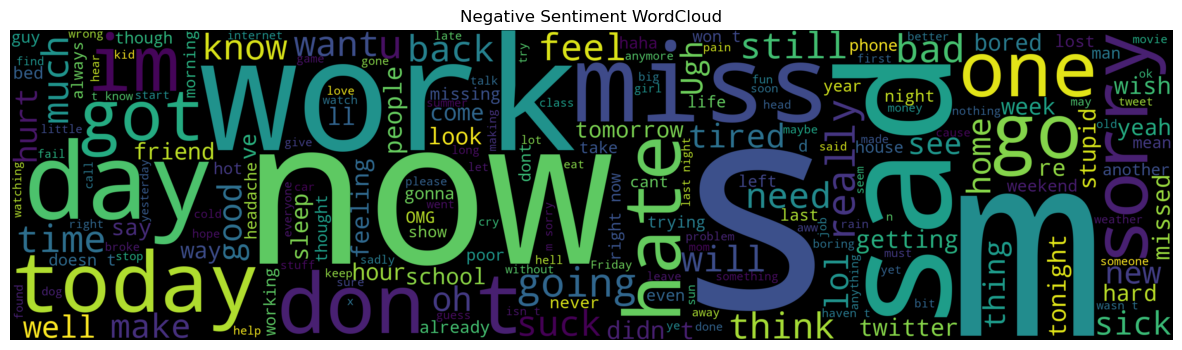

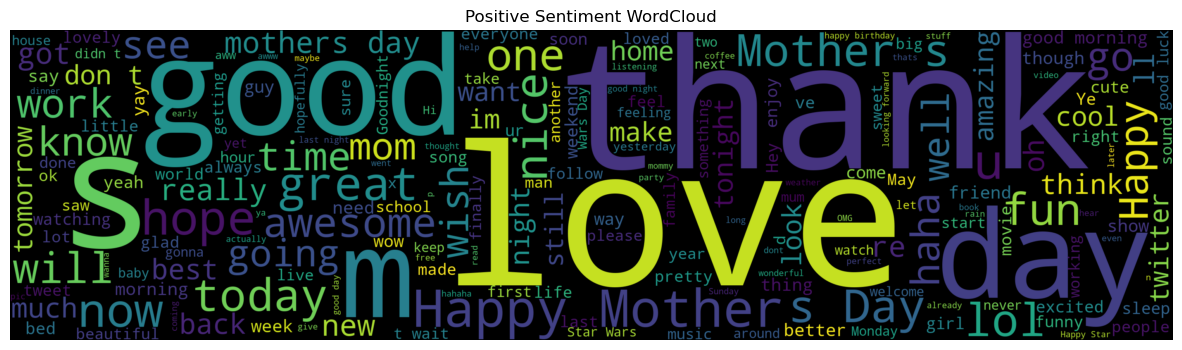

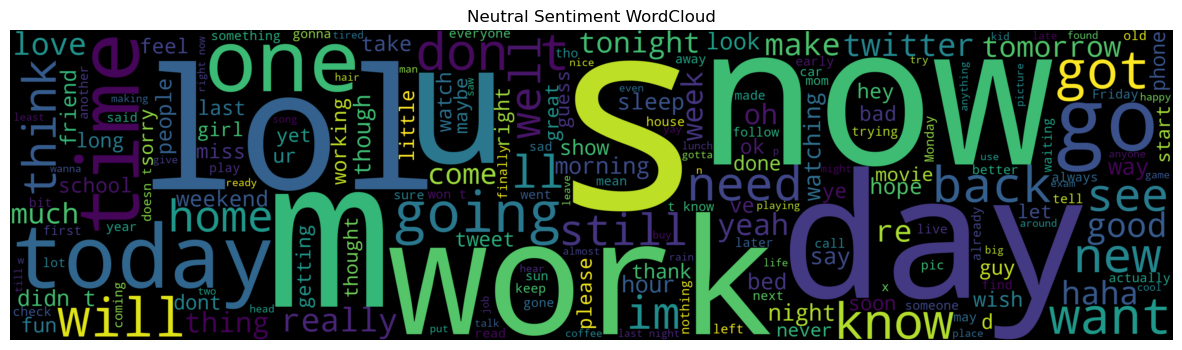

In [18]:
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black', 
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')


<p style="font-size:20px; font-family:verdana; line-height: 1.7em">- In the above word cloud there are certain words probably will not make too much sense to study the reason for negative sentiment and subsequently based on the frequency of these words we will decide if the same needs to be deleted </p> 


<a id="toc"></a>

<a href="#toc" style="background-color: #009dff; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>
<h2 align="left"><font color=#00a4f9>Basic Pre-Processing</font></h2>

In [19]:
# Convert text to lowercase
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removal of punctuations
df['text'].str.replace('[^\w\s]','')

#Removal of StopWords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head()

0                               i`d responded, going
1                         sooo sad miss san diego!!!
2                                boss bullying me...
3                             interview! leave alone
4    sons ****, couldn`t put releases already bought
Name: text, dtype: object

<a id="toc"></a>

<a href="#toc" style="background-color: #009dff; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>
<h2 align="left"><font color=#00a4f9>Common Words Removal</font></h2>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em">- Let's create a list of 10 frequently occurring words and then decide if we need to remove it or retain it</p> 

In [20]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:30]
freq

i`m       2173
day       1481
get       1415
good      1325
like      1303
it`s      1174
go        1162
-         1147
got       1069
going     1062
love      1060
happy      914
work       878
don`t      850
u          848
really     841
one        838
im         824
****       796
back       781
see        765
know       757
can`t      746
time       739
new        725
lol        697
want       695
&          675
still      661
think      656
Name: count, dtype: int64

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Let's remove "I'm", '-', '****', '& '<br>
    There can be other words too which can be removed, but let's conbtinue with above only </p>  

In [21]:
freq =["I'm", "-", "****", "&"]
df['text']= df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['text'].head()

0                               i`d responded, going
1                         sooo sad miss san diego!!!
2                                boss bullying me...
3                             interview! leave alone
4    sons ****, couldn`t put releases already bought
Name: text, dtype: object

In [22]:
#Rare Words Removal
#This is done as association of these less occurring words with the existing words could be a noise
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
freq

neaaarr                      1
wer                          1
sigh.....                    1
@_harrykim                   1
#design                      1
http://tinyurl.com/dl2upx    1
resources                    1
pours.                       1
cyalater!!!                  1
((hugs))                     1
Name: count, dtype: int64

In [23]:
#Stemming -refers to the removal of suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach¶
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['text'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0                               i`d responded, go
1                      sooo sad miss san diego!!!
2                                boss bulli me...
3                            interview! leav alon
4    son ****, couldn`t put releas alreadi bought
Name: text, dtype: object

In [24]:
df[target].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

                 Sentiment Variable Distribution                  


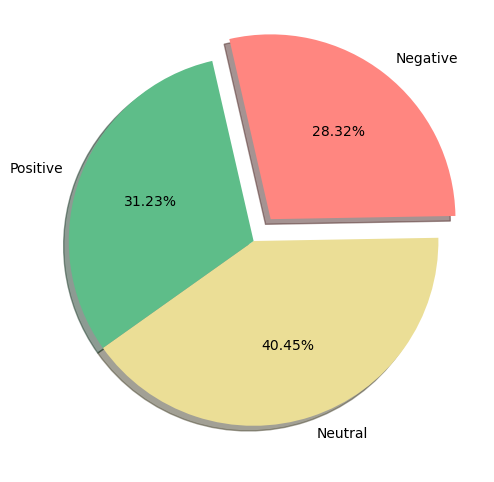

In [25]:
#Let's look at the overall distribution of positive, negative and neutral sentiments
print('\033[1mSentiment Variable Distribution'.center(70))
plt.figure(figsize=(12, 6))
colors = ['#ebde96', '#5ebd89', '#ff8680']
plt.pie(df[target].value_counts(), labels=['Neutral', 'Positive', 'Negative'], counterclock=False, shadow=True,
        explode=[0, 0, 0.15], autopct='%1.2f%%', radius=1, startangle=1, colors=colors)

plt.show()

<h3 align="left"><font color=#00a4f9>Let's visualize wordcloud post cleaning</font></h3>

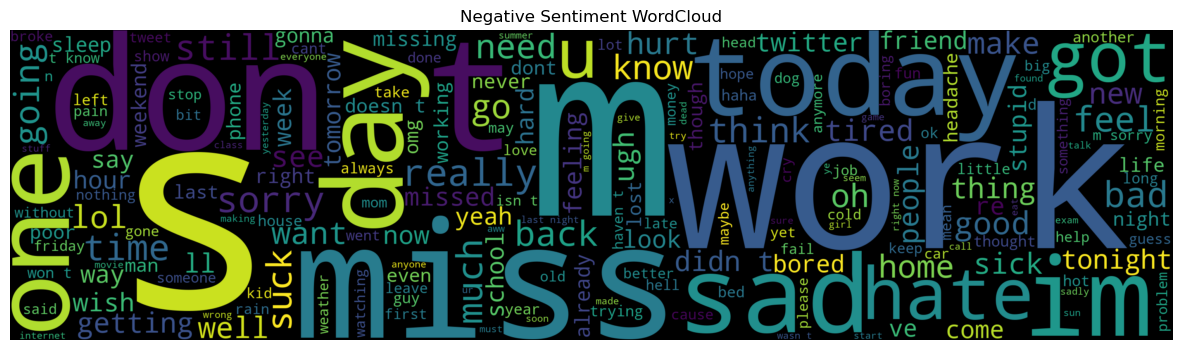

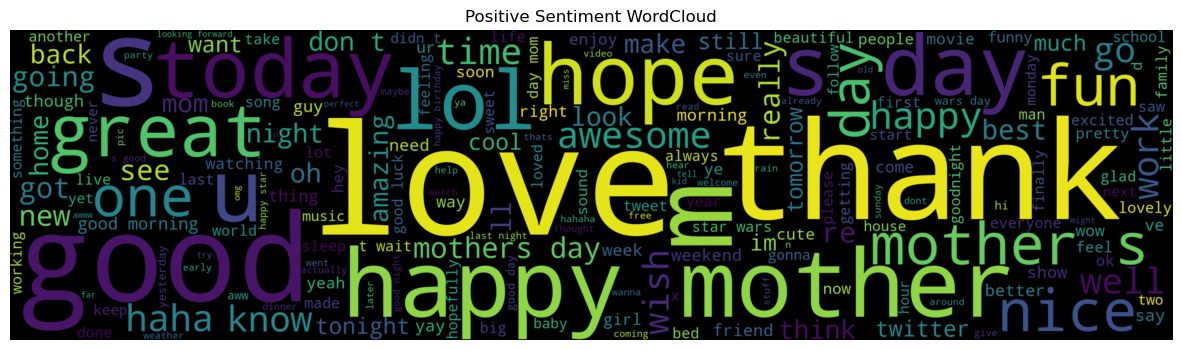

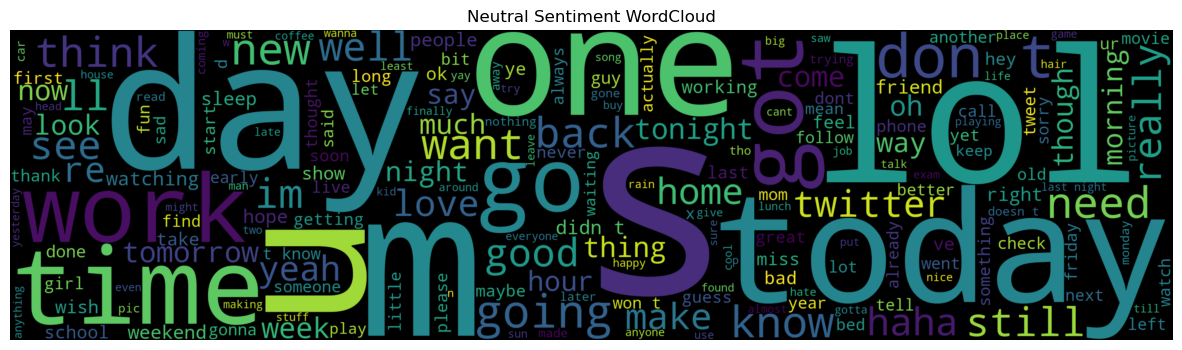

In [26]:
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black', 
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')


<a id="toc"></a>

<a href="#toc" style="background-color: #009dff; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>

<h2 align="left"><font color=#00a4f9>Predictive Modeling</font></h2>

In [27]:
X = df['text']
y = df['sentiment']

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer ()
X = vectorizer.fit_transform(X).toarray()
vectorizer

TfidfVectorizer()

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [30]:
#Let us create first create a table to store the results of various models 
results_df = pd.DataFrame(np.zeros((2,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
results_df.index=['Logistic Regression (LR)','Naïve Bayes Classifier (NB)'] #'Decision Tree Classifier (DT)', 'Linear Discriminant Analysis(LDA)','Random Forest Classifier (RF)', 'Support Vector Classifier (SVC)'
results_df

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [31]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [32]:
#Let us define functions to summarise the Prediction's scores .
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    results_df.iloc[i]['Accuracy']=round(accuracy_score(y_test, pred),3)*100   
    results_df.iloc[i]['Precision']=round(precision_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['Recall']=round(recall_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['F1-score']=round(f1_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['AUC/ROC score']=round(roc_auc_score(y_test, pred_prob, multi_class='ovr'),3)*100 #, multi_class='ovr'
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,results_df.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'),3)*100)) #, average='weighted'
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_test, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))
    
    auc_roc(y_test, pred_prob, curves=['each_class'])
    plt.show()

In [33]:
#Visualising Function
def AUC_ROC_plot(y_test, pred):    
    ref = [0 for _ in range(len(y_test))]
    ref_auc = roc_auc_score(y_test, ref)
    lr_auc = roc_auc_score(y_test, pred)

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ref)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(y_test, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

<h2 align="left"><font color=#00a4f9>Logistics Regression Model</font></h2>

In [34]:
# Building Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR = LR_model.fit(X_train, y_train)

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 68.5%
F1 Score = 68.4%

 Confusiton Matrix:
 [[ 848  589   86]
 [ 257 1775  243]
 [  51  505 1142]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.56      0.63      1523
     neutral       0.62      0.78      0.69      2275
    positive       0.78      0.67      0.72      1698

    accuracy                           0.69      5496
   macro avg       0.71      0.67      0.68      5496
weighted avg       0.70      0.69      0.68      5496



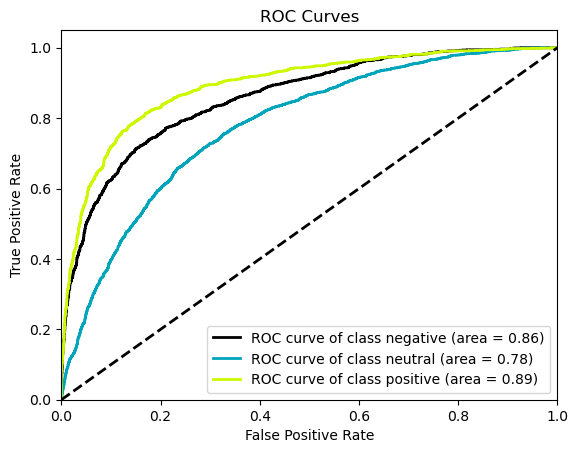

In [35]:
pred = LR.predict(X_test)
pred_prob = LR.predict_proba(X_test)
Classification_Summary(pred,pred_prob,0)


<a id="toc"></a>

<a href="#toc" style="background-color: #009dff; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>
<h2 align="left"><font color=#00a4f9>Naive Bayes Classfier</font></h2>

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 63.1%
F1 Score = 62.4%

 Confusiton Matrix:
 [[ 648  795   80]
 [ 217 1794  264]
 [  54  620 1024]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.43      0.53      1523
     neutral       0.56      0.79      0.65      2275
    positive       0.75      0.60      0.67      1698

    accuracy                           0.63      5496
   macro avg       0.67      0.61      0.62      5496
weighted avg       0.66      0.63      0.62      5496



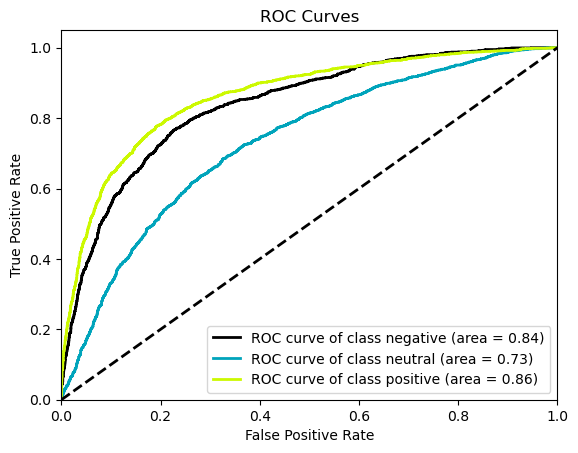

In [36]:
#Naive Bayes Classfier
NB_model = BernoulliNB()
NB = NB_model.fit(X_train, y_train)
pred = NB.predict(X_test)
pred_prob = NB.predict_proba(X_test)
Classification_Summary(pred,pred_prob,1)

<a id="toc"></a>

<a href="#toc" style="background-color: #009dff; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>
<h2 align="left"><font color=#00a4f9>Decision Tree ModelClassfier</font></h2>

In [37]:
#Decision Tree classifier
#DT_model = DecisionTreeClassifier()
#DT = DT_model.fit(X_train, y_train)
#pred = DT.predict(X_test)
#pred_prob = DT.predict_proba(X_test)
#Classification_Summary(pred,pred_prob,1)


<a id="toc"></a>

<a href="#toc" style="background-color: #00a4f9; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>
<h2 align="left"><font color=#00a4f9>Discriminant Analysis</font></h2>

In [38]:
#Discriminant Analysis
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#LDA_model = LinearDiscriminantAnalysis(solver='lsqr')  
#LDA = LDA_model.fit(X_train, y_train)
#pred = LDA.predict(X_test)
#pred_prob = LDA.predict_proba(X_test)
#Classification_Summary(pred,pred_prob,2)

<a id="toc"></a>

<a href="#toc" style="background-color: #00a4f9; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>
<h2 align="left"><font color=#00a4f9>Random Forest Model</font></h2>

In [39]:
#Random Forest Model
#RF_model = RandomForestClassifier()
#RF = RF_model.fit(X_train, y_train)
#pred = RF.predict(X_test)
#pred_prob = RF.predict_proba(X_test)
#Classification_Summary(pred,pred_prob,4)


<a id="toc"></a>

<a href="#toc" style="background-color: #00a4f9; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>
<h2 align="left"><font color=#00a4f9>SVC</font></h2>

In [40]:
#SVC
#SVC_model = SVC(probability=True)  
#SVC_clf = SVC_model.fit(X_train, y_train) 
#pred = SVC_clf.predict(X_test)
#pred_prob = SVC_clf.predict_proba(X_test)
#Classification_Summary(pred, pred_prob, 5)


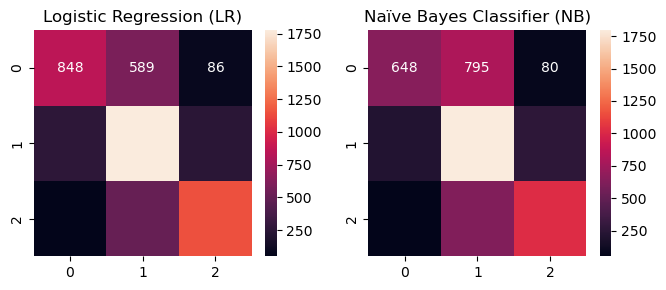

In [41]:
#Plotting Confusion-Matrix of all the predictive Models

import math
labels=['Positive','Negative']
def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"
    
def conf_mat_plot(all_models):
    plt.figure(figsize=[20,3*math.ceil(len([all_models])/4)])
    
    for i in range(len(all_models)):
        if len(labels)<=6:
            plt.subplot(1,6,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/2),2,i+1)
        pred = all_models[i].predict(X_test)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='.0f') 
        plt.title(results_df.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([LR, NB ]) #DT,RF,SVC_clf,LDA removed


In [42]:
#Comparing all the models Scores
display("Model Comparision",results_df)

'Model Comparision'

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),68.5,69.9,68.5,68.4,0.0
Naïve Bayes Classifier (NB),63.1,65.8,63.1,62.4,0.0


```Note: Not all models are run due to high computaional time. Codes are marked hidden ```


<div style="border-radius:10px; padding: 12px; background-color: #f2f6fc; font-size:100%; text-align:left">

<h2 align="left"><font color=#00a4f9> Final Words </font></h2>
<p style="font-size:18px; font-family:verdana; line-height: 1.7em">Since the Sentiment is imbalanced, and finding actual sentiment of the person is important,the metric to watch out for in this case can be F1 score which is nothing but the harmonic mean between precision and recall.</p>

<p style="font-size:18px; font-family:verdana; line-height: 1.7em">Precision and Recall are complementary metrics that have an inverse relationship. If both are of interest to us then we use the F1 score to combine precision and recall into a single metric.</p>